# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np

---
## 1. 加载数据：加载训练集-从中**分割验证集**，加载测试集
> Load and Visualize the Data(http://pytorch.org/docs/stable/torchvision/datasets.html)

+ 下载可能需要一些时间，并且在加载数据时应该会看到进度。 
+ 定义`transform`
+ 创建数据集2个dataset：--> 3种 DataLoader
+ 为每个数据集创建 DataLoader，关于DataLoader的参数
  + `dataset` (Dataset): dataset from which to load the data
  + `batch_size=` how many samples per batch to load (default: ``1``).
  + `shuffle=` (bool, optional): set to ``True`` to have the data reshuffled at every epoch (default: ``False``).
  + `sampler=` (Sampler, optional): defines the strategy to draw samples from the dataset. If specified, ``shuffle`` must be False.
   + 根据定义的‘策略’从‘数据集’中采样输入。如果定义采样规则，则洗牌（shuffle）设置必须为False。
  + `num_workers=` (int, optional): how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: ``0``)


In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# 数据载入第1步，设置数据载入的转换/处理
    #必要的是转换成tensor数据
transform = transforms.Compose([transforms.ToTensor()])

# 数据载入第2步，载入2种 dataset
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# 数据载入第3步 创建3个dataloader 而 Dataloader 作为迭代器，每次产生一个 batch 大小的数据，节省内存
    ## 切分indices
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Pytorch 语法1 分割验证集的方法
+ 必须获取训练数据集的indices，验证集从训练集中实现随机抽取数据是基于数据的index的
```python
num_train = len(train_data) # 
indices = list(range(num_train))
np.random.shuffle(indices)
```
  + 补充：
  ```python  
    >>> arr = np.arange(10)
    >>> np.random.shuffle(arr)
    >>> arr
    [1 7 5 2 9 4 3 6 0 8]
  ```   
  ---
  
```python 
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
```

+ 获取两个数据集的 indices  
  + 设置超参数 `valid_size=0.2` 然后 `valid_size * num_train` 表示取训练集的1/5作验证集
  + `np.floor(x)` 实现向下取‘整’，例如 `np.floor(2.7)` -> `2.`,
  + 而`np.int(x)` 实现返回整数， 例如`np.int(12000.0)` -> `12000`
  ---
 ```python
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
```   


+ 设置采样‘策略’
 + `SubsetRandomSampler(​indices​)`: ‘策略’是：从给定的索引列表(eg. `train_idx`)中不放回随机抽取元素，
 + print结果：<torch.utils.data.sampler.SubsetRandomSampler object at 0x0000025271CDC470>
 + type结果：torch.utils.data.sampler.SubsetRandomSampler   
 
```python
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
```

+ 实现从训练集中分割出0.2的验证集

---
**可视化一个batch的数据-检查 Visualize a Batch of Training Data**

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


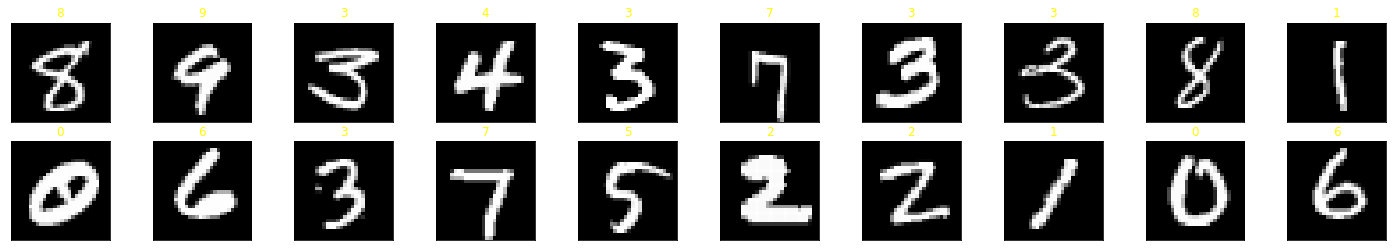

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()), color='Yellow')

**View an Image in More Detail**

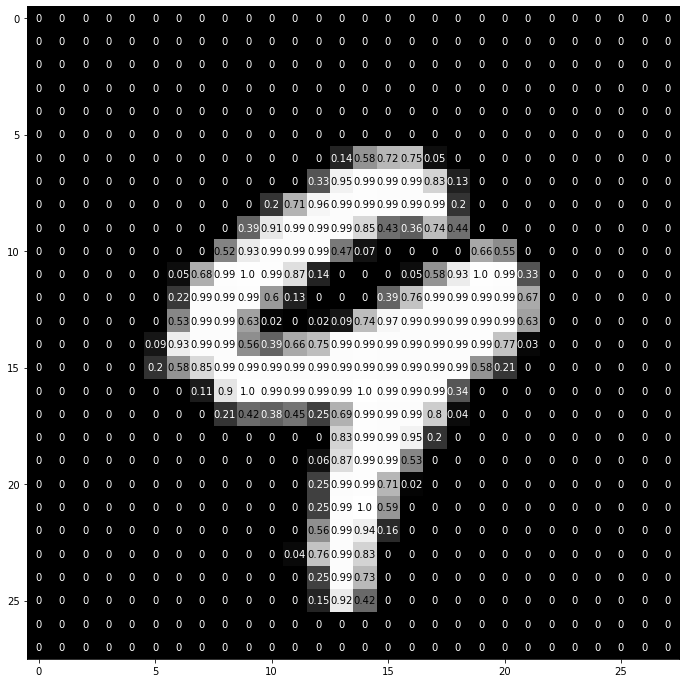

In [5]:
img = np.squeeze(images[1]) # 去掉维度为1的维度

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## 2. 定义网络结构

> Architecture http://pytorch.org/docs/stable/nn.html   

+ 此网络要求 784(28x28)的输入 tensor, 并output一个长度为10(class 的数量)的tensor，该tensor表示输入图像的class scores(使用log_softmax激活表示概率)
+ 这里我们使用两层隐藏层，注意使用dropout正则化避免过拟合

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
        self.dropput = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1) # (batch_size, 1*28*28)
        x = self.dropput(F.relu(self.fc1(x)))
        x = self.dropput(F.relu(self.fc2(x)))
        m = nn.LogSoftmax(dim=1)
        x = m(self.fc3(x))
        return x
model = Net()
model

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropput): Dropout(p=0.2, inplace=False)
)

---
## 3. 训练：神经网络   

+ 确定loss函数和优化器

> Loss Function (http://pytorch.org/docs/stable/nn.html#loss-functions)   

> Optimizer (http://pytorch.org/docs/stable/optim.html)

建议您使用交叉熵损失(cross-entropy loss)进行分类。 如果您查看文档（上面链接），您会发现PyTorch的交叉熵函数将softmax函数应用于输出层*，然后*计算对数损失。
+ 了解到cross-entropy loss实际上是两步，我们在结构中使用了logsofmax激活，则在损失函数可以定义使用NLLLoss

+ **设置epochs，循环epochs，**
+ 在训练之前决定的损失可视化策略：
 + 每个epoch 都输出validation loss
 + 随后，即在每个epoch都判断是否是最小的 validation loss， 若是保存当前模型为最优模型
   + 在完成所有epoch后，保存的最优模型用于测试test loss


下面的注释中描述了从a batch of data中进行训练/学习的步骤：
1. 首先clear**梯度**信息！
2. 前向计算网络输出
3. 对比输出与lable计算loss
4. loss 反向传播计算**梯度**
5. 优化更新**权重**
6. 更新平均训练损失累加器

以下循环训练了50个epochs 看一下训练损失的值如何随时间减少。 我们希望减少它，同时还要避免过度拟合训练数据

In [4]:
# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
epochs = 50 

# 初始化最小化验证损失的跟踪器
valid_loss_min = np.Inf # set initial "min" to infinity
# 绘制损失图像用的损失列表，元素是每个epoch的损失
train_losses, valid_losses = [], []
train_losses2, valid_losses2 = [], []
# cuda 判断启动
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device); # 不加分号会输出网络结构

for e in range(epochs):
    # monitor training loss/validation loss
    train_loss = 0
    valid_loss = 0
    
    train_loss2 = 0
    valid_loss2 = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss +=  loss.item()
        train_loss2 += loss.item() * images.size(0)
    
    
    ######################    
    # validate the model #
    # 只要损失，不是精度 #
    ######################
    model.eval()
    # 防止验证模型时爆显存
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            
            log_ps = model.forward(images)
            loss = criterion(log_ps, labels)
            valid_loss += loss.item()
            valid_loss2 += loss.item() * images.size(0)
            
    
    
    ########################################    
    # print training/validation statistics #
    # calculate average loss over an epoch #
    ######################################## 
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_loss2 = train_loss2/len(train_loader.sampler)
    valid_loss2 = valid_loss2/len(valid_loader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_losses2.append(train_loss2)
    valid_losses2.append(valid_loss2)
    
    print('Epoch {}/{}..'.format(e+1, epochs), 
                  'Train loss:{:.3f}..'.format(train_loss), 
                  'Test loss:{:.3f}..'.format(valid_loss))
    print('Epoch {}/{}..'.format(e+1, epochs), 
                  'Train loss2:{:.3f}..'.format(train_loss2), 
                  'Test loss2:{:.3f}..'.format(valid_loss2))

    #############################################    
    #save model if validation loss has decreased#
    #############################################
    if valid_loss <= valid_loss_min: # 初始时valid_loss_min 是无限大的
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss      # 替换最小验证损失


Epoch 1/50.. Train loss:0.018.. Test loss:0.014..
Epoch 1/50.. Train loss2:0.359.. Test loss2:0.283..
Validation loss decreased (inf --> 0.014169).  Saving model ...
Epoch 2/50.. Train loss:0.014.. Test loss:0.012..
Epoch 2/50.. Train loss2:0.279.. Test loss2:0.231..
Validation loss decreased (0.014169 --> 0.011557).  Saving model ...
Epoch 3/50.. Train loss:0.012.. Test loss:0.010..
Epoch 3/50.. Train loss2:0.232.. Test loss2:0.196..
Validation loss decreased (0.011557 --> 0.009809).  Saving model ...
Epoch 4/50.. Train loss:0.010.. Test loss:0.009..
Epoch 4/50.. Train loss2:0.196.. Test loss2:0.173..
Validation loss decreased (0.009809 --> 0.008669).  Saving model ...
Epoch 5/50.. Train loss:0.008.. Test loss:0.008..
Epoch 5/50.. Train loss2:0.169.. Test loss2:0.153..
Validation loss decreased (0.008669 --> 0.007655).  Saving model ...
Epoch 6/50.. Train loss:0.007.. Test loss:0.007..
Epoch 6/50.. Train loss2:0.150.. Test loss2:0.139..
Validation loss decreased (0.007655 --> 0.006973

### 关于网络保存

```python
torch.save(model.state_dict(), 'model.pt')
```

+ save it to a file：我们保存模型的方式是实际上保存一个字典 `state_dict`
  + 我们的模型的所有参数存储在模型的 `state_dict` 中，这是一个字典文件。 
  + 所有参数是指：模型每一层的权重和偏差矩阵
  
+ 最简单的事情使用 `torch.save(<>, <>)` 保存模型的参数。例如，我们可以将它保存到文件 `checkpoint.pth` 中
  + 执行这个语句之后，会在当前工作目录下生成一个 `checkpoint.pth` 文件

## Pytorch 语法2 两种 log_softmax 方法

使用 nn 的会报错 `nn.LogSoftmax`
`__init__()` got multiple values for argument 'dim'

```python
functional.log_softmax()
---
SIGNATURE
input,
dim=None,
_stacklevel=3,
dtype=None
```
+ Applies a softmax followed by a logarithm.
+ 虽然在数学上等同于log(softmax(x))，但单独执行这两种操作会更慢，而且在数值上不稳定。此函数使用一个替代公式来计算正确的输出和梯度。
+ ---
```python
CLASStorch.nn.LogSoftmax(dim: Optional[int] = None)
```
+ 应用 logsoftmax 函数到一个n维输入张量。LogSoftmax公式可以简化为
> https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html?highlight=torch%20nn%20logsoftmax#torch.nn.LogSoftmax

使用方法 Examples:
```python
>>> m = nn.LogSoftmax()
>>> input = torch.randn(2, 3)
>>> output = m(input)
```

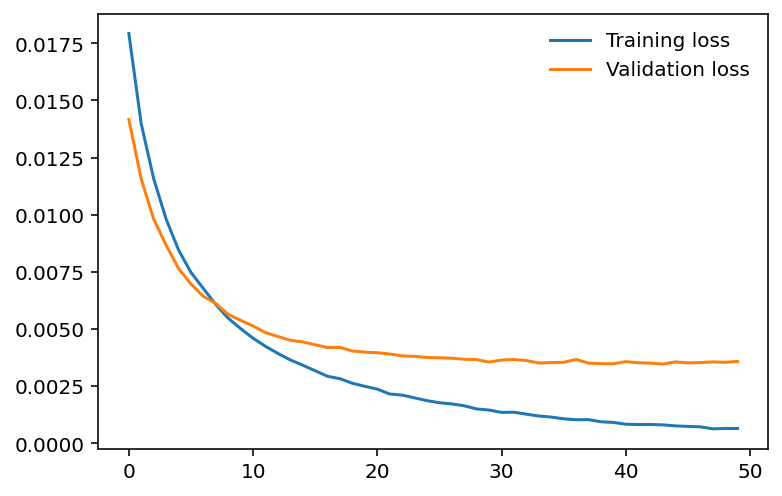

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False) 

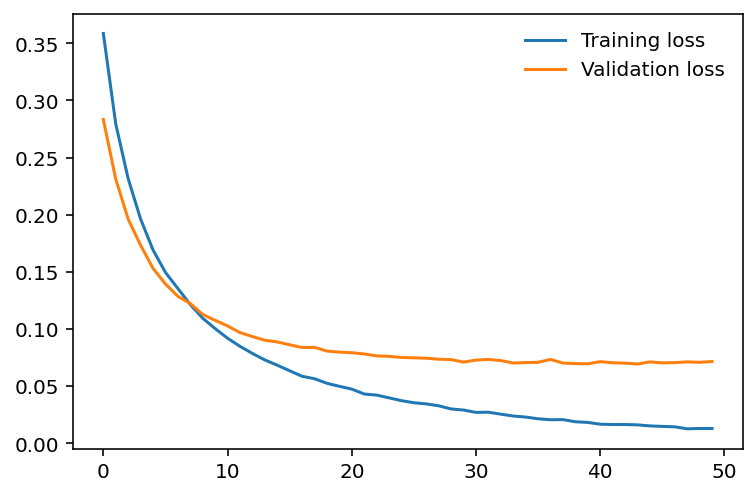

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses2, label='Training loss')
plt.plot(valid_losses2, label='Validation loss')
plt.legend(frameon=False) 

一个问题两种 loss 计算的方式研究：

```python
train_loss +=  loss.item()
train_loss2 += loss.item() * images.size(0)

train_loss = train_loss/len(train_loader.sampler)
train_loss2 = train_loss2/len(train_loader.sampler)
```

+ 首先第一部分的 `loss.item()` 代表了1个batch的损失，两句话的区别在于一个是计算这个batch的损失，一个是计算这个batch的损失再乘以这个batch的images的数量，这里是20，即 images.size(0)=20。使得损失相对第一种扩大了20倍

+ 第二部分：此时的分子train_loss代表一个epoch的叠加，再除以训练集中宗的images的数量==平均损失，
+ 这样看来 使用train_loss2似乎更合理些，因为对每个batch的images都关联到了损失？
  + 主要是要统一，包括和test loss统一。


---
## 4. 测试：测试保存的训练网络

最后，我们在从未见过的数据上测试保存的最佳模型，并评估它的表现。这是检查我们的模型泛化能力的好方法(输出test loss 和 accuracy)。 此外，在此分析中进行细化并查看该模型在每个类上的表现以及其总体损失和准确性可能也很有用。
我们也可以详细输出模型在每个类/class上的表现

###  Load the Model with the Lowest Validation Loss

+ model 是已经创建/加载过的了

In [8]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [15]:
print(model)
print(model.state_dict().keys())

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropput): Dropout(p=0.2, inplace=False)
)
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


测试过程和训练过程类似，但有以下需要注意的地方
+ 开启 eval/评估模式：关闭drop out
+ 可关闭梯度追踪，防止显存爆炸
+ 

In [17]:
list(0. for i in range(10))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device); # 不加分号会输出网络结构

# 当需要详细输出每个类的
class_correct = list(0. for i in range(10))  # [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
class_total = list(0. for i in range(10))
# 全部测试数据的测试误差累加器
test_loss = 0.0
accuracy = 0.0
# 遍历全部的 test 数据
model.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    # 总的loss
    test_loss += loss.item() * images.size(0)
    
    # accuracy
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1) # 返回64幅图对应预测的概率和class index，size为(64,1)
    equals = top_class == labels.view(*top_class.shape) # 64行1列的0，1 列表
    # 总的精确度
    accuracy += torch.mean(equals.type(torch.FloatTensor)) # 均值
    
    # 分别输出各类的精确度
    correct = np.squeeze(equals) # shape(64,)
    for i in range(len(labels)): # 现在是1个batch，循环例如64次(若 batch_size=64)
        label = labels.data[i]   # 第i幅图的label
        class_correct[label] += correct[i].item()
        class_total[label] += 1

######################################################################
# 当遍历完所有的测试数据之后，得到有test_loss；accuracy；class_correct #
# 求平均测试损失，和平均精度                                          #
#####################################################################
test_loss = test_loss/len(test_loader.sampler)
accuracy = accuracy/len(test_loader)
print('Test Loss: {:.6f}..'.format(test_loss), 
      'Accuracy: {:.4f}..'.format(accuracy))


for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.061029.. Accuracy: 0.9821..
Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 98% (993/1010)
Test Accuracy of     4: 98% (969/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 98% (941/958)
Test Accuracy of     7: 97% (1003/1028)
Test Accuracy of     8: 97% (950/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 98% (9821/10000)


代码段详解：
```python  
correct = np.squeeze(equals) # shape(64,)
    for i in range(len(labels)): # 现在是1个batch，循环例如64次(若 batch_size=64)
        label = labels.data[i]   # 第i幅图的label
        class_correct[label] += correct[i].item()
        class_total[label] += 1
```

这里的逻辑是：(若batch_size=64)
+ 在一个batch中，`correct` 是(64,) 的数据，每个元素对应的10个预测类正确与否(预测与label对比)即(1,0,0,1....)这样
+ for 循环64次 
  + `label = labels.data[i]` 得到 64 幅图对应的label例如[1,2,2,5,1]，遍历得的
  + 例如此时 i=4, label=5 代表第4幅图的label是 5， 则`class_correct[label]=class_correct[5]` 表示10个类中，数字是5的类的正确的数量
  + 初始`class_correct[5]`设为0，`correct[4].item()` 的值是指第四幅图预测正确还是错误，值是0或1
  + `class_correct[5] += correct[4].item()` 因为已知第4幅图的label是5，则这句话是求标签为5的类的正确预测数量，若第4附图预测正确，则`correct[4].item()=1` 则`class_correct[5]=class_correct[5]+1`，
  + 则遍历64幅图就可以知道将64幅图预测正确的类别计数出来

## Pytorch 语法3 Sampler 详解
> https://www.cnblogs.com/marsggbo/p/11541054.html   
> https://www.cnblogs.com/dogecheng/p/11930535.html

加不加 sampler的区别
```python
test_loss = test_loss/len(test_loader.sampler)
accuracy = accuracy/len(test_loader.sampler)
-----
len(test_loader) = 500
len(test_loader.sampler) = 10000
len(test_loader.dataset) = 10000
```

In [35]:
len(test_loader.dataset)

10000

### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

C:\Users\123\anaconda3\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


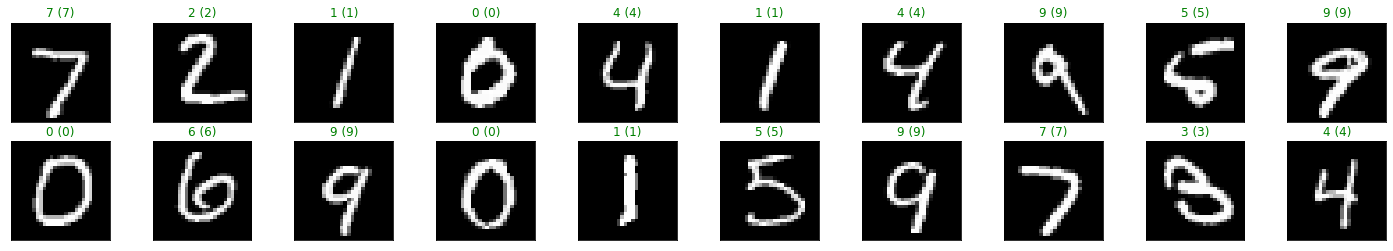

In [32]:
import matplotlib.pyplot as plt
model.to('cpu'); # 不加分号会输出网络结构
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to('cpu'), labels.to('cpu')

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))